## Amin Asadi 810196410
## Problems 9, 10, 11
##### Used Dataset: 
     - for problem 9 I used the provided TinyMNIST dataset in the "Data" folder(imported with the provided code)
     - For problem 10 and 11 I used full TinyMNIST dataset

### Problem 9
#### Used Libraries:
    - pandas, numpy
    - sklearn GaussianNB for implementing the classifier
    - matplotlib for plotting

#### Goal:
    - Implementing Sequential Forward Selection(SFS)

#### Description:
 High number of features in a dataset may lead to 'curse of dimmensionality'; Forward Selection is a method for finding a suitable smaller subset of features(dimmensions) of data so that we will have a more efficent model and avoid the mentioned problem.

#### Algorithm:
First we find the single feature that when chosen, leads to the best performance. Then from the remaining features we find the next feature that, with the first chosen feature they lead to the best performance. We continue this untill the accuracy does not increase.

In [1]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

### Importing Data:

In [2]:
# Loading Dataset
train_data = np.loadtxt('Data/TinyMNIST/trainData.csv', dtype=np.float32, delimiter=',')
train_labels = np.loadtxt('Data/TinyMNIST/trainLabels.csv', dtype=np.int32, delimiter=',')
test_data = np.loadtxt('Data/TinyMNIST/testData.csv', dtype=np.float32, delimiter=',')
test_labels = np.loadtxt('Data/TinyMNIST/testLabels.csv', dtype=np.int32, delimiter=',')
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Feature Selection
tr_samples_size, _ = train_data.shape
all_data = np.vstack((train_data,test_data))
sel = VarianceThreshold(threshold=0.90*(1-0.90))
all_data = sel.fit_transform(all_data)
train_data = all_data[:tr_samples_size]
test_data = all_data[tr_samples_size:]

tr_samples_size, feature_size = train_data.shape
te_samples_size, _ = test_data.shape
print('Train Data Samples:',tr_samples_size,
      ', Test Data Samples',te_samples_size,
      ', Feature Size(after feature-selection):', feature_size)

Train Data Samples: 5000 , Test Data Samples 2500 , Feature Size(after feature-selection): 62


In [3]:
X_train = train_data.copy()
X_test = test_data.copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

### SFS function implementation:

In [4]:
def sfs(max_features):
    fixed_set = []
    step_accs = []
    remaining_features = list(range(max_features))
    nbc = GaussianNB()

    while(len(remaining_features)):

        best_acc = -np.inf
        best_feature = None
        for f in remaining_features:
            
            fixed_set.append(f)
            sub_data = X_train[:, fixed_set].reshape(tr_samples_size, len(fixed_set))
            sub_target =  y_train.reshape(tr_samples_size, 1)
            nbc.fit(sub_data, sub_target)
            fixed_set.remove(f)

            score = nbc.score(sub_data, sub_target)
            if  score > best_acc:
                best_feature = f
                best_acc = score
        step_accs.append(best_acc)
        fixed_set.append(best_feature)
        remaining_features.remove(best_feature)

    return(step_accs)

step_accs = sfs(feature_size)

### A) Plotting the result:

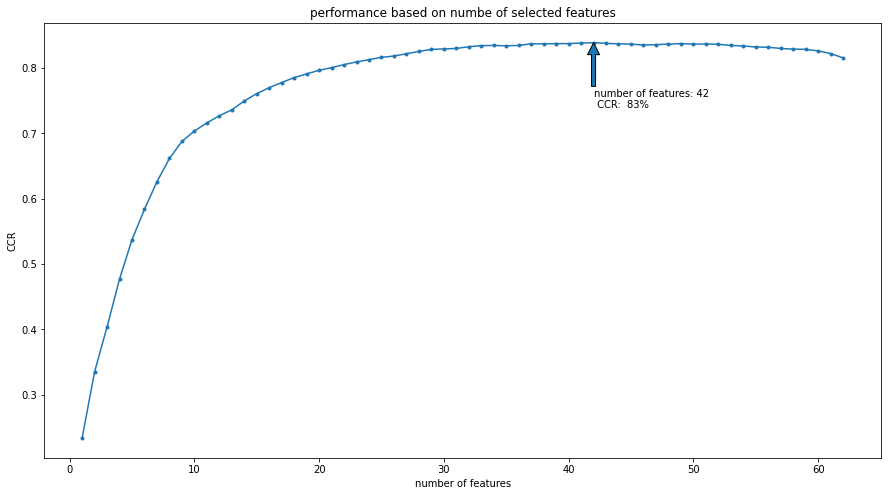

In [5]:
fig, ax = plt.subplots(figsize=(15,8))
x = np.arange(1, feature_size+1)
y = step_accs
y_max_idx = np.argmax(y)
x_max = x[y_max_idx]
y_max = np.max(y)
plt.plot(x, y, '.-');
plt.annotate('number of features: {} \n CCR:  {}%'.format(x_max, int(y_max*100)), (x_max, y_max), xytext=(x_max, y_max-0.1), arrowprops=dict())
plt.xlabel('number of features')
plt.ylabel('CCR')
plt.title('performance based on numbe of selected features');

### Result:
### B) As we can see from the above plot, the best number of features is: 42

# Problem 10:
 In this problem we use LDA to find the most important vectors to maximize the discriminability between classes. First we calculate within-class and between-class scatters and then find the projection matrix which is dot product of inverse of within-class scatter with the between-class scatter. Then we find the eigen values and eigen vectors of this obtained matrix and select most important features and then project the original data to only use that important features. Then we find the performance of gaussian naive bayes on the test data before transformation.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def inv(M):
    return np.linalg.inv(M)
     
def eig(M):
    return np.linalg.eig(M)

In [8]:
X_train = np.loadtxt('Data/TinyMNIST/trainData.csv', dtype=np.float32, delimiter=',')
y_train = np.loadtxt('Data/TinyMNIST/trainLabels.csv', dtype=np.int32, delimiter=',')
X_test = np.loadtxt('Data/TinyMNIST/testData.csv', dtype=np.float32, delimiter=',')
y_test = np.loadtxt('Data/TinyMNIST/testLabels.csv', dtype=np.int32, delimiter=',')

## 10-A:

### Calculating Within-Class Scatter:

In [9]:
# calculating within-class scatter matrix:
dim = X_train.shape[1]
s_w = np.zeros((dim, dim))

for i in range(len(class_names)):
    class_data = X_train[np.where(y_train==i)]
    class_mean = np.mean(class_data, axis=0)
    class_scatter = np.dot((class_data - class_mean).T, class_data - class_mean)
    s_w = s_w + class_scatter

### Calculating Between-Class Scatter:

In [10]:
total_mean = np.mean(X_train, axis=0)

s_b = np.zeros((X_train.shape[1], X_train.shape[1]))

for i in range(len(class_names)):
    class_data = X_train[np.where(y_train==i)]
    n_i = class_data.shape[0]
    class_mean = np.mean(class_data, axis=0)
    mean_diff = n_i * np.dot((class_mean - total_mean).T, class_mean - total_mean)
    s_b = s_b + mean_diff

In [11]:
np.linalg.det(s_w)

0.0

Because the within-class scatter is singuar we add a small amount to it to solve this singuarity:

In [12]:
s_w += np.identity(dim) * 1e-3

In [13]:
eig_vals, eig_vecs = eig(inv(s_w).dot(s_b))

In [14]:
eigval_eigvec = np.array(list(zip(np.abs(eig_vals), eig_vecs)))

In [15]:
decreasing_sorted = np.array(sorted(eigval_eigvec, key=lambda k : k[0], reverse=True))

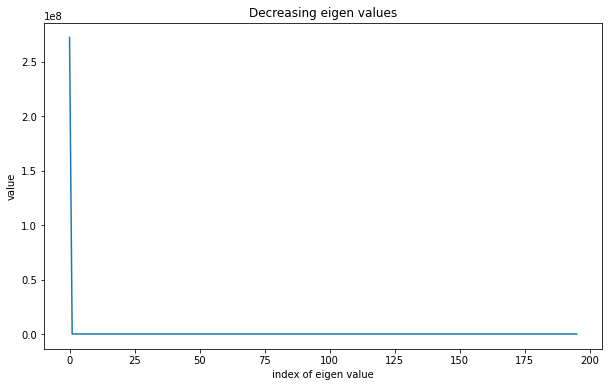

In [16]:
vals = decreasing_sorted[:,0]
fig,_ = plt.subplots(figsize=(10,6))
plt.plot(vals)
plt.title('Decreasing eigen values')
plt.xlabel('index of eigen value')
plt.ylabel('value');

As we can see one eigen value is very big and others are 0 so I dicide to use only one feature for new dataset.

## 10-B

In [17]:
projection_matrix = inv(s_w).dot(s_b)

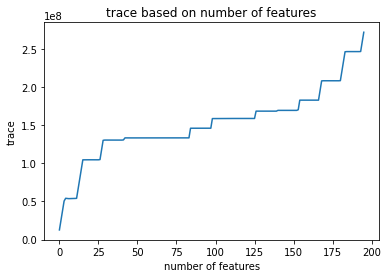

In [18]:
traces = []
cumulative_sum = 0
for i in range(len(projection_matrix)):
    cumulative_sum += projection_matrix[i][i]
    traces.append(cumulative_sum)

plt.plot(traces);
plt.title('trace based on number of features')
plt.xlabel('number of features')
plt.ylabel('trace');

#### Result: We see that trace increases by the number of features.

In [19]:
y = np.array([])
cumulative_sum = 0
for pair in decreasing_sorted:
    cumulative_sum += pair[0]
    y = np.append(y, cumulative_sum)
y = y*100 / y[-1]

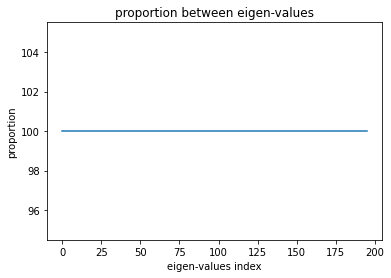

In [20]:
plt.plot(y)
plt.title('proportion between eigen-values')
plt.xlabel('eigen-values index')
plt.ylabel('proportion');

As we can see one features is the most important and in has 100% proportion so we choose only one best eigen vector to obtain projection matrix:

### 10-C: 
we have obtained best number of features=1, now we classify data with 1 feature and report the performance: 

### Using LDA without sklearn:

In [21]:
W = decreasing_sorted[0][1].reshape(-1,1)

In [22]:
trasformed_X_train = X_train.dot(W)
trasformed_X_test = X_test.dot(W)
nbc = GaussianNB()
nbc.fit(trasformed_X_train.real, y_train);
print('CCR before performing LDA = {}%'.format(nbc.score(X_test, y_test) * 100))
print('CCR after performing LDA = {}%'.format(nbc.score(trasformed_X_test.real, y_test) * 100))

CCR before performing LDA = 10.96%
CCR after performing LDA = 22.88%


### Using LDA with sklearn:

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
lda.fit(X_train, y_train)
trasformed_X_train = lda.transform(X_train)
trasformed_X_test = lda.transform(X_test)
nbc = GaussianNB()
nbc.fit(trasformed_X_train.real, y_train);
print('CCR before performing LDA = {}%'.format(nbc.score(X_test, y_test) * 100))
print('CCR after performing LDA = {}%'.format(nbc.score(trasformed_X_test.real, y_test) * 100))

CCR before performing LDA = 10.16%
CCR after performing LDA = 34.36%


### Result:
As we can see choosing the best feature has imporved the accuracy both in our implementation and in sklearn implementation.

# Problem 11


#### Goal:
    - Implementing Principal Component Analysis(PCA)

#### Description:
 As mentioned in problem 10, high number of features in a dataset may lead to 'curse of dimmensionality'; PCA is a usefull method for descreasing number of dimmensions.

#### Algorithm:
- First we split the data to train and test data.
- Then we normalize the train and then normalize test data with the mean and std of train data. Normalization is necessary because we will use it as a fact in the formulas.
- Then we find the covariance matrix of train data.
- Then we find the eigen values and eigen vectors of the obtained ovariance matrix.
- After that we sort the the eigen values in descreasing order. Then we find the first d biggest eigen values which cover 90 percent of the data variance and then construct a transformation matrix based on the d corresponding eigen vectors.
- After that we stack the d obtained eigen vectors to form the transformation matrix.
- Then we transform the train and test data with that transformation matrix.

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def inv(M):
    return np.linalg.inv(M)
     
def eig(M):
    return np.linalg.eig(M)

In [25]:
X_train = np.loadtxt('Data/TinyMNIST/trainData.csv', dtype=np.float32, delimiter=',')
y_train = np.loadtxt('Data/TinyMNIST/trainLabels.csv', dtype=np.int32, delimiter=',')
X_test = np.loadtxt('Data/TinyMNIST/testData.csv', dtype=np.float32, delimiter=',')
y_test = np.loadtxt('Data/TinyMNIST/testLabels.csv', dtype=np.int32, delimiter=',')

### Step 1: NORMALIZATION:

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Step 2: COVARIANCE MATRIX COMPUTATION

In [27]:
cov = np.cov(X_train.T, ddof=0)

### 

### 11-A) STEP 3: EIGENVECTORS AND EIGENVALUES

In [28]:
eig_vals, eig_vecs = eig(cov)

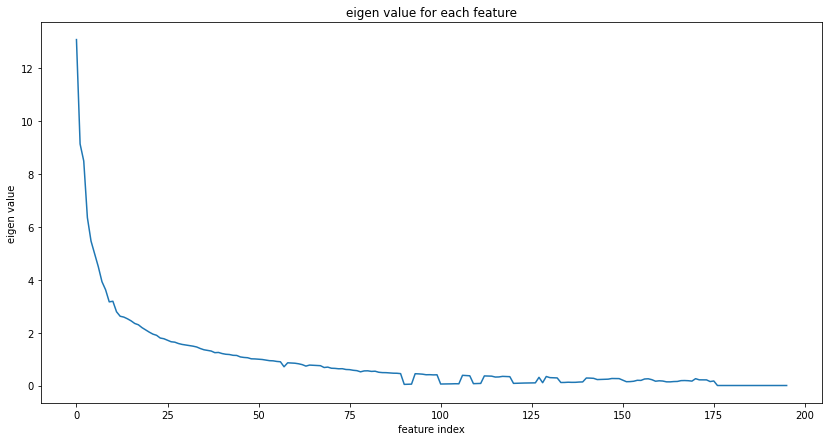

In [29]:
plt.figure(figsize=(14,7))
plt.plot(eig_vals);
plt.xlabel('feature index');
plt.ylabel('eigen value');
plt.title('eigen value for each feature');

In [30]:
eig_vecs.shape

(196, 196)

### STEP 4: Finding principal features


In [31]:
sorted_eig = sorted(list(zip(eig_vals, eig_vecs)),key=lambda k : k[0], reverse=True)

In [32]:
y = np.array([])
cumulative_sum = 0
for pair in sorted_eig:
    cumulative_sum += pair[0]
    y = np.append(y, cumulative_sum)
y = y*100 / y[-1]

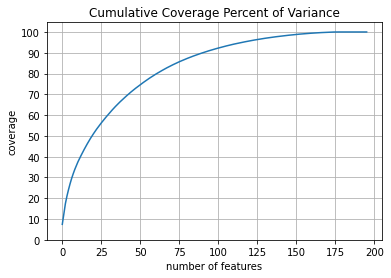

In [33]:
plt.plot(y)
plt.grid()
plt.yticks(np.arange(0,110,10))
plt.xlabel('number of features')
plt.ylabel('coverage')
plt.title('Cumulative Coverage Percent of Variance');

### 11-B) We can see that about 30 features is enough to cover 90% of data variance

In [34]:
VARIANCE_BOUND = 90
idx = np.where(y >= VARIANCE_BOUND)[0][0]

number_of_principal_features = idx + 1
number_of_principal_features

91

In [35]:
print('Least number of feature for covering 90% variance of the data =', number_of_principal_features)

Least number of feature for covering 90% variance of the data = 91


### 11-C) STEP 5: DATA TRANSFORMATION ALONG THE PRINCIPAL COMPONENTS AXES

#### Now we use sklearn PCA with 91 features that we obtained and transform out train and test datasets:

In [36]:
pca = PCA(n_components=number_of_principal_features)
pca.fit(X_train)
transformed_X_train = pca.transform(X_train) 
transformed_X_test = pca.transform(X_test)

### Performance before performing PCA:

In [37]:
nbc = GaussianNB()
nbc.fit(X_train, y_train)
print('CCR before performing PCA  = {}%'.format(nbc.score(X_test, y_test) * 100))

CCR before performing PCA  = 47.36%


### Performance after performing PCA:

In [38]:
nbc = GaussianNB()
nbc.fit(transformed_X_train, y_train)
print('CCR after performing PCA = {}%'.format(nbc.score(transformed_X_test, y_test) * 100))

CCR after performing PCA = 54.76%


### Result:
 We seee the althogh we used only half of the features the performance is nearly the same as before. So PCA has helped us to decrease the dimmension from 196 to 91 but the performance is not decreased much. So PCA performed good but not optimal.